In [1]:
pip install numpy pandas pyquaternion scikit-learn seaborn

Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import pickle
import numpy as np
import pandas as pd
from pyquaternion import Quaternion
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier

# --- AYARLAR ---
# Veri setinin bulunduğu ana klasör
BASE_DATASET_FOLDER = ""
# Analiz edilecek hareket
MOVEMENT_TO_ANALYZE = ""
# Analize dahil edilecek kullanıcılar
USERS_TO_ANALYZE = ["User-A","User-B","User-C", "User-D", "User-E"]

# Grafiklerin daha güzel görünmesi için stil ayarı
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk") # Grafikleri daha okunaklı yapar
print("Kütüphaneler ve ayarlar hazır.")

Kütüphaneler ve ayarlar hazır.


In [7]:
def reshape_from_pkl(frames_list):
    """
    .pkl'den okunan 'düz' listeyi, her sensör için bir DataFrame
    içeren bir listeye dönüştürür.
    """
    num_sensors = 10
    all_sensor_data = []
    for frame in frames_list:
        frame_sensors = []
        if len(frame) == num_sensors * 4:
            for i in range(num_sensors):
                x, y, z, w = frame[i*4:i*4+4]
                frame_sensors.append({'w': w, 'x': x, 'y': y, 'z': z})
            all_sensor_data.append(frame_sensors)
    
    sensor_data_frames = []
    for i in range(num_sensors):
        sensor_i_timeseries = [frame[i] for frame in all_sensor_data]
        sensor_data_frames.append(pd.DataFrame(sensor_i_timeseries))
    return sensor_data_frames


In [8]:
def get_statistical_features(timeseries):
    return {'mean': np.mean(timeseries), 'std': np.std(timeseries), 'min': np.min(timeseries), 'max': np.max(timeseries), 'range': np.max(timeseries) - np.min(timeseries)}

def get_quaternion_features(quat_df, prefix):
    features = {}
    for component in ['w', 'x', 'y', 'z']:
        stats = get_statistical_features(quat_df[component])
        for stat_name, value in stats.items(): features[f'{prefix}_{component}_{stat_name}'] = value
    return features

def calculate_relative_quaternions(df1, df2):
    relative_frames = []
    for i in range(len(df1)):
        q1 = Quaternion(w=df1.iloc[i]['w'], x=df1.iloc[i]['x'], y=df1.iloc[i]['y'], z=df1.iloc[i]['z'])
        q2 = Quaternion(w=df2.iloc[i]['w'], x=df2.iloc[i]['x'], y=df2.iloc[i]['y'], z=df2.iloc[i]['z'])
        relative_q = q2.inverse * q1
        relative_frames.append({'w': relative_q.w, 'x': relative_q.x, 'y': relative_q.y, 'z': relative_q.z})
    return pd.DataFrame(relative_frames)

def extract_features_for_movement(normalized_data):
    all_features = {}
    for i, sensor_df in enumerate(normalized_data): all_features.update(get_quaternion_features(sensor_df, f's{i+1}'))
    all_features.update(get_quaternion_features(calculate_relative_quaternions(normalized_data[1], normalized_data[4]), 'rel_s2_s5'))
    all_features.update(get_quaternion_features(calculate_relative_quaternions(normalized_data[0], normalized_data[1]), 'rel_s1_s2'))
    all_features.update(get_quaternion_features(calculate_relative_quaternions(normalized_data[2], normalized_data[7]), 'rel_s3_s8'))
    return all_features


In [9]:
import os
import pickle
import numpy as np
import pandas as pd
from pyquaternion import Quaternion
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- AYARLAR ---
BASE_DATASET_FOLDER = ""
MOVEMENT_TO_ANALYZE = ""
USERS_TO_ANALYZE = ["User-A", "User-B", "User-C", "User-D", "User-E"]

# --- YENİ NORMALİZASYON MANTIĞI ---

def normalize_by_first_frame(movement_data_list):
    """
    Bir hareket kaydını, ayrı bir referans dosyası yerine
    kendi ilk anına göre normalize eder.
    """
    if not movement_data_list: return None
    
    # Referans olarak hareketin kendisini kullan
    npose_data_list = movement_data_list 
    
    normalized_movement = []
    for i in range(len(movement_data_list)):
        q_ref_row = npose_data_list[i].iloc[0]
        q_ref = Quaternion(w=q_ref_row['w'], x=q_ref_row['x'], y=q_ref_row['y'], z=q_ref_row['z'])
        q_ref_inverse = q_ref.inverse
        
        normalized_frames = []
        for row in movement_data_list[i].itertuples():
            live_quat = Quaternion(w=row.w, x=row.x, y=row.y, z=row.z)
            normalized_quat = q_ref_inverse * live_quat
            normalized_frames.append({'w': normalized_quat.w, 'x': normalized_quat.x, 'y': normalized_quat.y, 'z': normalized_quat.z})
            
        normalized_movement.append(pd.DataFrame(normalized_frames))
    return normalized_movement

# --- VERİ YÜKLEME VE YENİ NORMALİZASYON ---
all_movements_new_norm = []
print(f"'{MOVEMENT_TO_ANALYZE}' hareketi için YENİ normalizasyon ile veri yükleniyor...")

for user_id in USERS_TO_ANALYZE:
    user_path = os.path.join(BASE_DATASET_FOLDER, MOVEMENT_TO_ANALYZE, user_id)
    if not os.path.isdir(user_path): continue
    
    print(f"-> {user_id} işleniyor...")
    for label_folder in os.listdir(user_path):
        label_path = os.path.join(user_path, label_folder)
        if not os.path.isdir(label_path) or label_folder.startswith('tpose'): continue
        
        for movement_file in os.listdir(label_path):
            if not movement_file.startswith("movement_"): continue
            
            with open(os.path.join(label_path, movement_file), 'rb') as f:
                movement_dict = pickle.load(f)
            
            movement_raw = reshape_from_pkl(movement_dict['data'])
            # DİKKAT: normalize_by_first_frame fonksiyonu çağrılıyor
            movement_normalized = normalize_by_first_frame(movement_raw) 
            
            all_movements_new_norm.append({'data': movement_normalized, 'label': label_folder, 'user': user_id})

print(f"\nİşlem tamamlandı. Toplam {len(all_movements_new_norm)} hareket yeni yöntemle normalize edildi.")


'' hareketi için YENİ normalizasyon ile veri yükleniyor...
-> User-A işleniyor...
-> User-B işleniyor...
-> User-C işleniyor...
-> User-D işleniyor...
-> User-E işleniyor...

İşlem tamamlandı. Toplam 300 hareket yeni yöntemle normalize edildi.


In [18]:
# --- ÖZELLİK ÇIKARIMI VE MODELLEME ---
print("\nYeni normalize edilmiş veri ile özellik çıkarımı başlıyor...")
feature_list_new_norm = []
for movement in all_movements_new_norm:
    features = extract_features_for_movement(movement['data']) # Bu fonksiyon öncekiyle aynı
    features['label'] = movement['label']
    features['user'] = movement['user']
    feature_list_new_norm.append(features)

features_df_new_norm = pd.DataFrame(feature_list_new_norm)
print("Özellik çıkarımı tamamlandı.")

print(features_df_new_norm.head())
features_df_new_norm.to_csv('my_features.csv', index=False)



Yeni normalize edilmiş veri ile özellik çıkarımı başlıyor...
Özellik çıkarımı tamamlandı.
   s1_w_mean  s1_w_std  s1_w_min  s1_w_max  s1_w_range  s1_x_mean  s1_x_std  \
0   0.844577  0.157437  0.551157  1.000000    0.448843  -0.116481  0.066469   
1   0.843001  0.159427  0.553387  1.000000    0.446613  -0.091107  0.058683   
2   0.815399  0.172877  0.510417  1.000009    0.489592  -0.064153  0.043845   
3   0.822335  0.164494  0.536765  1.000022    0.463257  -0.078993  0.050829   
4   0.848521  0.144847  0.600408  1.000009    0.399601  -0.063143  0.052794   

   s1_x_min      s1_x_max  s1_x_range  ...  rel_s3_s8_y_min  rel_s3_s8_y_max  \
0 -0.221803 -5.551115e-17    0.221803  ...        -0.054033         0.069452   
1 -0.162301  2.382844e-02    0.186130  ...        -0.022152         0.148059   
2 -0.125562  9.698748e-03    0.135260  ...        -0.066441         0.097448   
3 -0.157695  5.567274e-03    0.163262  ...        -0.039069         0.132737   
4 -0.140236  1.589243e-02    0.156

In [13]:
pip install xgboost

  Using cached xgboost-3.0.5-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached nvidia_nccl_cu12-2.28.3-py3-none-manylinux_2_18_x86_64.whl.metadata (2.0 kB)
Using cached xgboost-3.0.5-py3-none-manylinux_2_28_x86_64.whl (94.9 MB)
Using cached nvidia_nccl_cu12-2.28.3-py3-none-manylinux_2_18_x86_64.whl (295.9 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xgboost]m1/2 [xgboost]
Note: you may need to restart the kernel to use updated packages.



--- Model Comparison with First-Frame Normalization ---


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:33:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:33:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:33:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:33:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13


--- Final Model Comparison ---
                 Model  Average Accuracy  Average F1-Score
0        Random Forest          0.946667          0.943947
4              XGBoost          0.936667          0.933374
3                  KNN          0.930000          0.920595
2  Logistic Regression          0.913333          0.901166
1                  SVM          0.860000          0.823663


/tmp/ipykernel_151/2931340770.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Model", y="Average F1-Score", data=summary_df, palette="viridis")


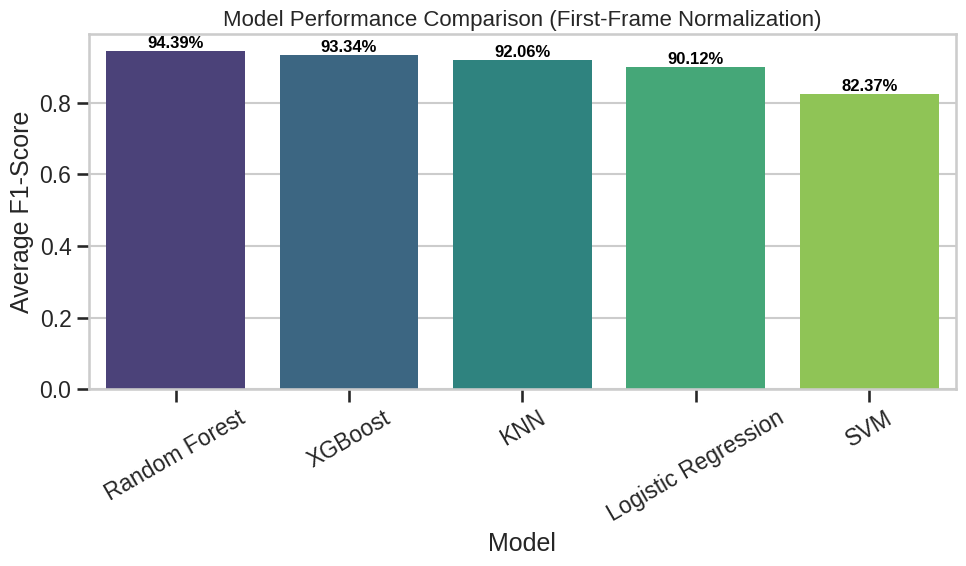

In [16]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
# Özellikleri (X) ve etiketleri (y) ayır
X_new = features_df_new_norm.drop(['label', 'user'], axis=1)
y_str_new = features_df_new_norm['label']

# Özellikleri ölçeklendir
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_new)

groups_new = features_df_new_norm['user']
le_new = LabelEncoder().fit(y_str_new)
y_new = le_new.transform(y_str_new)

# Modelleri tanımla
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42,n_jobs=1),
    "KNN": KNeighborsClassifier(n_neighbors=5,n_jobs=1),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42,n_jobs=1)
}

logo = LeaveOneGroupOut()
results = {name: [] for name in models.keys()}

print("\n--- Model Comparison with First-Frame Normalization ---")

# Her model için Leave-One-Group-Out CV
for train_idx, test_idx in logo.split(X_new, y_new, groups_new):
    X_train, X_test = X_new.iloc[train_idx], X_new.iloc[test_idx]
    y_train, y_test = y_new[train_idx], y_new[test_idx]

    scaler = StandardScaler().fit(X_train)
    X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="weighted")
        results[name].append({"accuracy": acc, "f1_score": f1})

# Sonuçları özetle
summary = []
for name, scores in results.items():
    avg_acc = np.mean([s["accuracy"] for s in scores])
    avg_f1 = np.mean([s["f1_score"] for s in scores])
    summary.append({"Model": name, "Average Accuracy": avg_acc, "Average F1-Score": avg_f1})

summary_df = pd.DataFrame(summary).sort_values("Average F1-Score", ascending=False)
print("\n--- Final Model Comparison ---")
print(summary_df)

# Sonuçları grafikle göster
plt.figure(figsize=(10,6))
ax = sns.barplot(x="Model", y="Average F1-Score", data=summary_df, palette="viridis")

# Çubukların üzerine değerleri yaz
for p in ax.patches:
    ax.annotate(f"{p.get_height()*100:.2f}%",  # yüzdelik format
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=12, color='black', fontweight='bold')

plt.title("Model Performance Comparison (First-Frame Normalization)", fontsize=16)
plt.ylabel("Average F1-Score")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("model_comparison_firstframe.png")
plt.show()

In [42]:
# --- AYARLAR ---
# 1. BU DEĞİŞKENİ HER HAREKET İÇİN GÜNCELLE
MOVEMENT_NAME = "ShoulderAbduction" 


# 2. 'features_df' DATAFRAME'İNİN JUPYTERLAB'DE YÜKLÜ OLDUĞUNDAN EMİN OL.

# Modellerin kaydedileceği klasör
OUTPUT_FOLDER = "final_models"
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)
    print(f"'{OUTPUT_FOLDER}' klasörü oluşturuldu.")
    

# Özellikleri (X) ve etiketleri (y) ayır
X = features_df_new_norm.drop(['label', 'user'], axis=1)
y_str = features_df_new_norm['label']
groups = features_df_new_norm['user']

le = LabelEncoder().fit(y_str)
y = le.transform(y_str)



# Modelleri tanımla
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
}

logo = LeaveOneGroupOut()
results = {name: [] for name in models.keys()}

print(f"\n--- {MOVEMENT_NAME} için Model Karşılaştırması Başlıyor ---")

# Her model için Leave-One-User-Out CV
for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    scaler = StandardScaler().fit(X_train)
    X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="weighted")
        results[name].append({"accuracy": acc, "f1_score": f1})

# Sonuçları özetle
summary = []
for name, scores in results.items():
    avg_acc = np.mean([s["accuracy"] for s in scores])
    avg_f1 = np.mean([s["f1_score"] for s in scores])
    summary.append({"Model": name, "Average Accuracy": avg_acc, "Average F1-Score": avg_f1})

summary_df = pd.DataFrame(summary).sort_values("Average F1-Score", ascending=False)
print(f"\n--- {MOVEMENT_NAME} için Final Model Karşılaştırması ---")
print(summary_df)

# --- BÖLÜM 2: TÜM MODELLERİ EĞİTME VE KAYDETME ---

print(f"\n{'='*20} {MOVEMENT_NAME.upper()} İÇİN FİNAL MODELLERİ EĞİTİLİYOR VE KAYDEDİLİYOR {'='*20}")

# Tüm veriyi kullanarak nihai ölçekleyiciyi hazırla
final_scaler = StandardScaler()
X_scaled_final = final_scaler.fit_transform(X)

# Her bir modeli TÜM veriyle son bir kez eğit ve kaydet
for model_name, model_instance in models.items():
    print(f"  -> Model: {model_name}...")
    
    # Modeli bu harekete özel tüm veriyle eğit
    model_instance.fit(X_scaled_final, y)
    
    # Dosya adlarını oluştur
    model_filename = f"final_model_{MOVEMENT_NAME}_{model_name}.pkl"
    scaler_filename = f"final_scaler_{MOVEMENT_NAME}_{model_name}.pkl"
    le_filename = f"final_label_encoder_{MOVEMENT_NAME}_{model_name}.pkl"
    
    # Dosyaları kaydet
    pickle.dump(model_instance, open(os.path.join(OUTPUT_FOLDER, model_filename), "wb"))
    pickle.dump(final_scaler, open(os.path.join(OUTPUT_FOLDER, scaler_filename), "wb"))
    pickle.dump(le, open(os.path.join(OUTPUT_FOLDER, le_filename), "wb"))
    
    print(f"     ✅ Kaydedildi: {model_filename}")

print(f"\n{'='*20} {MOVEMENT_NAME.upper()} İÇİN TÜM MODELLER BAŞARIYLA OLUŞTURULDU {'='*20}")





--- ShoulderAbduction için Model Karşılaştırması Başlıyor ---


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [04:47:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [04:47:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [04:47:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [04:47:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13


--- ShoulderAbduction için Final Model Karşılaştırması ---
                Model  Average Accuracy  Average F1-Score
0        RandomForest          0.946667          0.943947
4             XGBoost          0.936667          0.933374
3                 KNN          0.930000          0.920595
2  LogisticRegression          0.913333          0.901166
1                 SVM          0.860000          0.823663

==================== SHOULDERABDUCTION İÇİN FİNAL MODELLERİ EĞİTİLİYOR VE KAYDEDİLİYOR ====================
  -> Model: RandomForest...
     ✅ Kaydedildi: final_model_ShoulderAbduction_RandomForest.pkl
  -> Model: SVM...
     ✅ Kaydedildi: final_model_ShoulderAbduction_SVM.pkl
  -> Model: LogisticRegression...
     ✅ Kaydedildi: final_model_ShoulderAbduction_LogisticRegression.pkl
  -> Model: KNN...
     ✅ Kaydedildi: final_model_ShoulderAbduction_KNN.pkl
  -> Model: XGBoost...


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [04:47:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


     ✅ Kaydedildi: final_model_ShoulderAbduction_XGBoost.pkl

==================== SHOULDERABDUCTION İÇİN TÜM MODELLER BAŞARIYLA OLUŞTURULDU ====================


In [4]:
pip install tensorflow

  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.8/620.8 MB 22.4 MB/s  0:00:23m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 35.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 30.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 36.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 32.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 37.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 27.7 MB/s  0:00:00m0:00:0100:01
Using cached setuptools-80.9.0-py3-none-any.whl (1.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32/32 [tensorflow]2 [tensorflow]]py]a-server]
Note: you may need to restart the kernel to use updated packages.


In [26]:
import os
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder

# --- AYARLAR ---
# 1. Model dosyalarınızın bulunduğu klasör
MODELS_FOLDER = "final_models" 
# 2. .tflite dosyalarının kaydedileceği klasör
TFLITE_OUTPUT_FOLDER = "tflite_models"
# 3. Modelini dönüştürmek istediğiniz hareketin adı (dosya adıyla eşleşmeli)
MOVEMENT_NAME = "ShoulderAbduction"
# 4. Hangi scikit-learn modelini baz alacağınız (dosya adıyla eşleşmeli)
MODEL_TYPE = "XGBoost"

# --- YENİ AYAR ---
# 5. Model eğitme betiğinizde oluşturup kaydettiğiniz özellik (features) CSV dosyasının yolu
# ÖNEMLİ: Bu dosyayı diğer Python betiğinizden `features_df_new_norm.to_csv('my_features.csv', index=False)`
# komutuyla oluşturmanız gerekmektedir.
FEATURES_CSV_PATH = 'my_features.csv' 


def create_keras_model(input_shape, num_classes):
    """
    TFLite'a dönüştürmek için basit bir Keras modeli oluşturur.
    Bu model, scikit-learn modelinin karmaşıklığını taklit etmeye çalışır.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=[input_shape]),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax') # Sınıflandırma için softmax
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def convert_to_tflite():
    """
    Belirtilen hareket ve model tipi için .pkl dosyalarını yükler,
    bir Keras modeli eğitir ve TFLite formatında kaydeder.
    """
    print(f"--- {MOVEMENT_NAME} - {MODEL_TYPE} için TFLite dönüştürme işlemi başlıyor ---")
    
    # --- 1. Gerekli .pkl Dosyalarını Yükleme ---
    try:
        scaler_path = os.path.join(MODELS_FOLDER, f"final_scaler_{MOVEMENT_NAME}_{MODEL_TYPE}.pkl")
        le_path = os.path.join(MODELS_FOLDER, f"final_label_encoder_{MOVEMENT_NAME}_{MODEL_TYPE}.pkl")
        
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)
        with open(le_path, 'rb') as f:
            label_encoder = pickle.load(f)
            
        print("✅ Scaler ve LabelEncoder başarıyla yüklendi.")
    except FileNotFoundError as e:
        print(f"❌ HATA: Gerekli .pkl dosyaları bulunamadı: {e}")
        print("Lütfen `MODELS_FOLDER` yolunu ve dosya adlarını kontrol edin.")
        return

    # --- 2. Veri Setini Hazırlama ---
    try:
        features_df_new_norm = pd.read_csv(FEATURES_CSV_PATH)
        print(f"✅ Gerçek veri seti '{FEATURES_CSV_PATH}' dosyasından başarıyla yüklendi.")
    except FileNotFoundError:
        print(f"❌ HATA: '{FEATURES_CSV_PATH}' dosyası bulunamadı.")
        print("Lütfen diğer Python betiğinizde özellik verilerinizi içeren CSV dosyasını oluşturup")
        print("bu betikteki `FEATURES_CSV_PATH` değişkenini doğru şekilde ayarladığınızdan emin olun.")
        return
    except Exception as e:
        print(f"❌ HATA: Veri seti yüklenirken bir sorun oluştu: {e}")
        return

    # 'user' sütunu varsa çıkar, çünkü Keras modelinin buna ihtiyacı yok
    if 'user' in features_df_new_norm.columns:
        features_df_new_norm = features_df_new_norm.drop('user', axis=1)

    X = features_df_new_norm.drop(['label'], axis=1, errors='ignore')
    y_str = features_df_new_norm['label']

    # Veriyi, kaydedilmiş scaler ve encoder ile dönüştür
    X_scaled = scaler.transform(X)
    y_encoded = label_encoder.transform(y_str)

    print("✅ Veri seti yüklendi ve işlendi.")

    # --- 3. Keras Modelini Eğitme ---
    input_shape = X_scaled.shape[1]
    num_classes = len(label_encoder.classes_)
    
    keras_model = create_keras_model(input_shape, num_classes)
    
    print(f"Keras modeli {input_shape} girdi ve {num_classes} çıktı ile oluşturuldu.")
    print("Model eğitiliyor...")
    
    keras_model.fit(X_scaled, y_encoded, epochs=50, batch_size=16, validation_split=0.2, verbose=1)
    
    print("✅ Model başarıyla eğitildi.")
    
    # --- 4. Modeli TFLite Formatına Dönüştürme ---
    converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
    tflite_model = converter.convert()
    
    if not os.path.exists(TFLITE_OUTPUT_FOLDER):
        os.makedirs(TFLITE_OUTPUT_FOLDER)
        
    tflite_filename = f"{MOVEMENT_NAME}_{MODEL_TYPE}.tflite"
    tflite_filepath = os.path.join(TFLITE_OUTPUT_FOLDER, tflite_filename)
    
    with open(tflite_filepath, 'wb') as f:
        f.write(tflite_model)
        
    print(f"✅ Model başarıyla '{tflite_filepath}' adresine kaydedildi.")
    print("--- İşlem Tamamlandı ---")


if __name__ == '__main__':
    # Gerekli kütüphanelerin yüklü olduğundan emin olun:
    # pip install tensorflow pandas scikit-learn
    convert_to_tflite()



--- ShoulderAbduction - XGBoost için TFLite dönüştürme işlemi başlıyor ---
✅ Scaler ve LabelEncoder başarıyla yüklendi.
✅ Gerçek veri seti 'my_features.csv' dosyasından başarıyla yüklendi.
✅ Veri seti yüklendi ve işlendi.
Keras modeli 260 girdi ve 4 çıktı ile oluşturuldu.
Model eğitiliyor...
Epoch 1/50


/opt/conda/envs/python313/lib/python3.13/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8083 - loss: 0.6405 - val_accuracy: 0.9167 - val_loss: 0.2169
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9958 - loss: 0.1079 - val_accuracy: 0.9167 - val_loss: 0.1589
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9958 - loss: 0.0468 - val_accuracy: 0.8833 - val_loss: 0.1989
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9958 - loss: 0.0286 - val_accuracy: 0.9000 - val_loss: 0.1672
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0115 - val_accuracy: 0.9667 - val_loss: 0.1150
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0101 - val_accuracy: 0.9500 - val_loss: 0.1113
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.9333 - val_loss: 0.1226
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9958 - loss: 0.0135 - val_accuracy: 0.9667 - val_loss: 0.1014
Ep

INFO:tensorflow:Assets written to: /tmp/tmpvaet5z33/assets


Saved artifact at '/tmp/tmpvaet5z33'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 260), dtype=tf.float32, name='keras_tensor_35')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139719117688656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139719117695184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139719117693648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139719112378704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139719112379280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139719112385424: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Model başarıyla 'tflite_models/ShoulderAbduction_XGBoost.tflite' adresine kaydedildi.
--- İşlem Tamamlandı ---


W0000 00:00:1760438467.950940     151 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1760438467.950959     151 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-10-14 12:41:07.951153: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpvaet5z33
2025-10-14 12:41:07.951671: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-10-14 12:41:07.951679: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpvaet5z33
2025-10-14 12:41:07.956066: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-10-14 12:41:07.986135: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpvaet5z33
2025-10-14 12:41:07.994303: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 43153 microseconds.
